# Introduction


This is a short overview over the features of the `quantumsim` package, from the perspective of a user.

## Circuits

`quantumsim.circuit` contains the `Circuit` class, which hold a set of named qubits (but not their state) and a sequence of 
gates that are applied to the qubits. As an example, a CNOT gate can be implemented like this:



In [1]:
import numpy as np
from quantumsim.circuit import Circuit

t1, t2 = 3000, 1500

c = Circuit(title="CNOT gate")
c.add_qubit("A", t1, t2)
c.add_qubit("B", t1, t2)

c.add_hadamard("B", time=0)
c.add_hadamard("B", time=40)
c.add_cphase("A", "B", time=20);

The circuit can be plotted, using `matplotlib`:

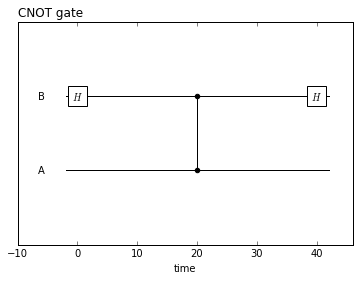

In [2]:
%matplotlib inline
c.plot();

# Measurements

Measurement gates are added as any other gate, but they require additional information in form of a "sampler".
The sampler specifies how the measurement outcomes (and declared outcomes) are determined.

Here, we use a "uniform noisy sampler", which will use a random number generator to sample from 
the projection probabilities (as expected in an experiment), but also sometimes (we choose 3%) declares the wrong outcome.

In order to obtain the declared outcome, we create a bit that obtains the measurement output. 
It is formally a qubit, but since is never put in a superposition, it will be efficiently implemented.


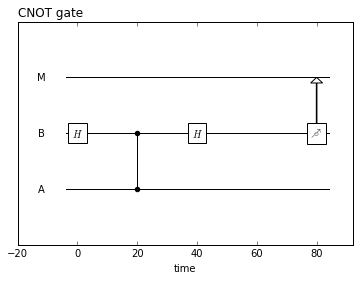

In [3]:
from quantumsim.circuit import uniform_noisy_sampler

c.add_qubit("M")

sampler = uniform_noisy_sampler(readout_error=0.03, seed=42)

c.add_measurement("B", time=80, output_bit="M", sampler=sampler);

c.plot();

# Rest gates

Gates are always assumed to be applied perfectly. 
Besides the declaration error of the measurement, we have not yet introduced any source of error.

The main source of error is in fact $T_1$ and $T_2$ decay. These are added automatically as rest gates inbetween any 
two other gates, using the `add_waiting_gates` function. Note that the measurement qubit has no rest gates added,
because we did not specify any `t1`, `t2` when creating it.

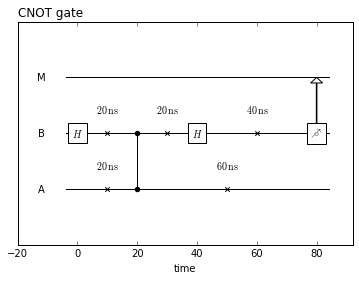

In [4]:
c.add_waiting_gates()
c.plot();

## Simulation

Now we are ready to simulate the circuit. 

The state of the qubits is held in a `quantumsim.sparsedm.SparseDM` object (a "sparse density matrix"), which is where the magic happens.

We create a `SparseDM` with the same qubit names as used in the circuit.

In [5]:
from quantumsim.sparsedm import SparseDM

sdm = SparseDM(c.get_qubit_names())

When loading `sparsedm`, an automatic check is performed whether an NVidia CUDA runtime and the pycuda package are available to perform computation on a GPU. If not, a cython-based backend is used. You can check which one is used:

In [6]:
import quantumsim.sparsedm
print("GPU is used:", quantumsim.sparsedm.using_gpu)

GPU is used: False


Each qubit of the `SparseDM` can be either "classical" or "quantum". If it is classical, its state is 0 or 1 (in computational basis), and not correlated to the state of any other qubit. Initially, all qubits are in the ground state. We flip the control bit A so that something happens.

In [7]:
sdm.classical['A'] = 1
print("initial state:", sdm.classical)

initial state: {'M': 0, 'A': 1, 'B': 0}


Now we apply the circuit. Before we can do that, we must instruct the circuit to bring its gates in the best correct order.

In [8]:
c.order()
c.apply_to(sdm)

Whenever a gate acts on a qubit, it becomes "quantum", meaning it becomes part of the big density matrix `sdm.full_dm`. Whenever a gate is measured and projected, it becomes classical again. After application of the circuit, the control bit A will thus be quantum. The measured bit B and the declared measurement outcome M should be 1 (unless an error occured), because the CNOT flips B.

In [9]:
print("classical bits after one round:", sdm.classical)

classical bits after one round: {'M': 1, 'B': 1}


We can obtain the probability that this measurement outcome actually would be observed:

In [10]:
print("probability:", sdm.trace())

probability: 0.94144220072


Let's run the whole circuit for a number of times and look at the declared outcome to see what happens.

In [11]:
measurements = []

for i in range(150):
    c.apply_to(sdm)
    measurements.append(sdm.classical['M'])

print("150 rounds of outcomes of CNOT+measurement:")
print(measurements)

150 rounds of outcomes of CNOT+measurement:
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


As we can see, the qubit B toggles each round as long as A is the 1 state, but after a while A decays and the flipping stops. 
Then, B is constant 1, but some point, B suffers a decay as well and is constant 0.

Then, an occasional declaration error is observed.

The probability that exactly this trace is observed is now vanishingly small:

In [12]:
print("probability:", sdm.trace())

probability: 1.87508569889e-11


We can keep the state in `sdm`, but reset this probability:

In [13]:
sdm.renormalize()
print("probability:", sdm.trace())

probability: 1.0


And finally apply one more round and thus obtain the conditional probability of the 152nd measurement outcome given the history of the previous outcomes:

In [14]:
c.apply_to(sdm)
print("152nd measurement:", sdm.classical['M'])
print("conditional probability:", sdm.trace())

152nd measurement: 0
conditional probability: 0.960523555257


The probability is larger than for the first round because the two qubits A and B are in the ground state now, and have less opportunity to decay.